In [1]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

1329524


In [13]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn
import ImageAnalysis3 as ia3
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast
from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.correction_tools.alignment import generate_drift_crops
from ChromAn.src.spot_tools.match_spots import colocalize_spots

import pickle

In [14]:
import matplotlib.pyplot as plt

In [15]:
# data folder
data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907'
# scan subfolders
folders, fovs = data_organization.search_fovs_in_folders(data_folder)
# analysis folder
analysis_folder = os.path.join(data_folder, 'Analysis')
# figure_folder
figure_folder = os.path.join(analysis_folder, 'saved_figures_20231018')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

- searching in folder: /lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907
-- 17 folders, 325 fovs detected.


In [16]:
color_usage_filename = os.path.join(analysis_folder, "Color_Usage.csv")
color_usage_df = data_organization.Color_Usage(color_usage_filename)

- load color_usage from file: /lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907/Analysis/Color_Usage.csv


In [17]:
save_folder = analysis_folder
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
import re
match = re.match(r'.*_([0-9]+).hdf5', os.path.basename(save_filenames[0]), ).groups()[0]
save_filenames = [_f for _f in sorted(save_filenames, 
                                      key=lambda _v:int(re.match(r'.*_([0-9]+).hdf5', os.path.basename(_v), ).groups()[0]))]

In [18]:
processed_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                       if '_processed_info.pkl' in _fl]
processed_filenames = [_f for _f in sorted(processed_filenames, 
                                      key=lambda _v:int(re.match(r'.*_([0-9]+)_processed_info.pkl', os.path.basename(_v), ).groups()[0]))]

print(len(processed_filenames))

116


In [31]:
# load infos:
all_intbc_ims = []
all_edit_ims = []
for _fl in processed_filenames:
    #print(_fl)
    _fov_info = pickle.load(open(_fl, 'rb'))
    for _info in _fov_info:
        if np.shape(_info['intbc_ims']) != (21,7,7,7) or np.shape(_info['edit_ims']) != (27,7,7,7):
            continue
        all_intbc_ims.append(_info['intbc_ims'])
        all_edit_ims.append(_info['edit_ims'])
    # extract all edits ims
    print(f" loaded {len(_fov_info)} from file: {os.path.basename(_fl)}")

all_intbc_ims = np.array(all_intbc_ims)
all_edit_ims = np.array(all_edit_ims)

print(f"- {len(all_intbc_ims)} in total")

 loaded 67 from file: Conv_zscan_003_processed_info.pkl
 loaded 63 from file: Conv_zscan_004_processed_info.pkl
 loaded 23 from file: Conv_zscan_005_processed_info.pkl
 loaded 62 from file: Conv_zscan_006_processed_info.pkl
 loaded 58 from file: Conv_zscan_007_processed_info.pkl
 loaded 53 from file: Conv_zscan_008_processed_info.pkl
 loaded 11 from file: Conv_zscan_009_processed_info.pkl
 loaded 58 from file: Conv_zscan_010_processed_info.pkl
 loaded 34 from file: Conv_zscan_011_processed_info.pkl
 loaded 30 from file: Conv_zscan_012_processed_info.pkl
 loaded 89 from file: Conv_zscan_013_processed_info.pkl
 loaded 38 from file: Conv_zscan_014_processed_info.pkl
 loaded 25 from file: Conv_zscan_015_processed_info.pkl
 loaded 29 from file: Conv_zscan_016_processed_info.pkl
 loaded 51 from file: Conv_zscan_017_processed_info.pkl
 loaded 22 from file: Conv_zscan_018_processed_info.pkl
 loaded 84 from file: Conv_zscan_019_processed_info.pkl
 loaded 54 from file: Conv_zscan_020_processed_i

In [32]:
# Save to temp location
temp_folder = r'/lab/solexa_weissman/puzheng/PE_LT/Analysis/0913_top8'
if not os.path.isdir(temp_folder):
    os.makedirs(temp_folder)
# ims files:
intbcIm_filename = os.path.join(temp_folder, 'intbc_ims.npy')
editIm_filename = os.path.join(temp_folder, 'edit_ims.npy')
print(intbcIm_filename, editIm_filename)
np.save(intbcIm_filename, all_intbc_ims)
np.save(editIm_filename, all_edit_ims)

/lab/solexa_weissman/puzheng/PE_LT/Analysis/0913_top8/intbc_ims.npy /lab/solexa_weissman/puzheng/PE_LT/Analysis/0913_top8/edit_ims.npy


In [10]:
# reload from here:
temp_folder = r'/lab/solexa_weissman/puzheng/PE_LT/Analysis/0913_top8'
if 'all_intbc_ims' not in locals():
    
    intbcIm_filename = os.path.join(temp_folder, 'intbc_ims.npy')
    editIm_filename = os.path.join(temp_folder, 'edit_ims.npy')
    print(intbcIm_filename, editIm_filename)
    all_intbc_ims = np.load(intbcIm_filename, )
    all_edit_ims = np.load(editIm_filename, )


# Load codebook

In [33]:
codebook_filename = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/NewTargetSites/IntBC_MERFISH/full_codebook.csv'
codebook = pd.read_csv(codebook_filename)

In [39]:
# re-evaluate
valid_list = [0,364,348,255,270,265,263,283,227,356,369,314,341,305,74,68,64,101,99,95,17,14,12,11,30]
sel_barcode_ids = np.array(optimize_obj.barcode_ids)[np.array(optimize_obj.barcode_ids) >= 0]
len([_id for _id in sel_barcode_ids if _id in valid_list]) / len(sel_barcode_ids), np.mean(np.array(optimize_obj.barcode_ids) >= 0)


(0.9746192893401016, 0.45714285714285713)

In [40]:
# mimic MERLin Optimization, prepare data:
def find_image_background(im, dtype=None, bin_size=10, make_plot=False, max_iter=10):
    """Function to calculate image background
    Inputs: 
        im: image, np.ndarray,
        dtype: data type for image, numpy datatype (default: np.uint16) 
        bin_size: size of histogram bin, smaller -> higher precision and longer time,
            float (default: 10)
    Output: 
        _background: determined background level, float
    """
    from scipy.signal import find_peaks
    if dtype is None:
        dtype = im.dtype 
    _cts, _bins = np.histogram(im, 
                               bins=np.arange(np.iinfo(dtype).min, 
                                              np.iinfo(dtype).max,
                                              bin_size)
                               )
    _peaks = []
    # gradually lower height to find at least one peak
    _height = np.size(im)/50
    _iter = 0
    while len(_peaks) == 0:
        _height = _height / 2 
        _peaks, _params = find_peaks(_cts, height=_height)
        _iter += 1
        if _iter > max_iter:
            break
    # select highest peak
    if _iter > max_iter:
        _background = np.nanmedian(im)
    else:
        _sel_peak = _peaks[np.argmax(_params['peak_heights'])]
        # define background as this value
        _background = (_bins[_sel_peak] + _bins[_sel_peak+1]) / 2
    # plot histogram if necessary
    if make_plot:
        import matplotlib.pyplot as plt
        plt.figure(dpi=100)
        plt.hist(np.ravel(im), bins=np.arange(np.iinfo(dtype).min, 
                                              np.iinfo(dtype).max,
                                              bin_size))
        plt.xlim([np.min(im), np.max(im)])     
        plt.show()

    return _background

class Optimization_decode():
    """
    An analysis class for decoding MERFISH data
    """
    def __init__(self, codebook_filename, 
                 color_usage_filename=None,
                 parameter_filename=None,
                 verbose=True,
                 ):
        # direct inputs
        self.verbose = verbose
        # load inputs
        self.codebook_filename = codebook_filename
        self._load_codebook()
        self.color_usage_filename = color_usage_filename
        self._load_color_usage()
        # paramters
        self.parameter_filename = parameter_filename
        self.prev_scale_factors = []
        self.prev_backgrounds = []

    def _load_color_usage(self):
        """
        Load color usage from file
        """
        if not hasattr(self, 'color_usage_df') or self.color_usage_df is None:
            if self.verbose:
                print(f"-- loading color usage from file: {self.color_usage_filename}")
            self.color_usage_df = data_organization.Color_Usage(self.color_usage_filename, verbose=False)
        else:
            pass
    
    def _load_codebook(self):
        """
        Load codebook from file
        """
        if not hasattr(self, 'codebook') or self.codebook is None:
            if self.verbose:
                print(f"-- loading codebook from file: {self.codebook_filename}")
            self.codebook = pd.read_csv(self.codebook_filename)
        else:
            pass
    
    def _load_images(self, cropped_ims):
        """
        include loaded images into the class, for now its a test case
        """
        # add loaded images
        self.ims = np.array(cropped_ims)
        return
    
    def _init_scale_factors(
            self, 
            n_bins=4000,      
            scale_max=0.99,
        ) -> np.ndarray:
        """
        initialize scale factors
        """
        self.scale_factors = np.ones((self.ims.shape[0], self.ims.shape[1]), dtype=np.float32)
        data_type = self.ims.dtype
        ## TODO: add reading for bits information
        bits = np.arange(self.ims.shape[1])
        scale_factors, backgrounds = [], []
        for bit in bits:
            # calculate cumulative histogram
            counts, intensities =  np.histogram(np.array(self.ims)[:,bit], bins=np.arange(np.iinfo(data_type).min, 
                                                                                np.iinfo(data_type).max+1,
                                                                                (np.iinfo(data_type).max+1 - np.iinfo(data_type).min)/n_bins))
                                                                                
            intensities = (intensities[:-1] + intensities[1:]) / 2
            cumsum_counts = np.cumsum(counts)
            cumsum_counts = cumsum_counts / cumsum_counts[-1]

            # calculate background
            background = find_image_background(np.array(self.ims)[:,bit], )
            backgrounds.append(background)
            scaling_factor = np.ceil(intensities[np.argmin(np.abs(cumsum_counts - scale_max))])
            #scale_factors.append(max(scaling_factor - background, 1))
            scale_factors.append(scaling_factor+1)
            print(bit, scaling_factor, background) 
        # add attribute
        self.scale_factors = np.array(scale_factors)
        self.backgrounds = np.array(backgrounds)
        return np.array(scale_factors), np.array(backgrounds)
        
    def _get_previous_scale_factors(self) -> np.ndarray:
        if 'previous_iteration' not in self.parameters:
            scaleFactors = self._init_scale_factors()
        else:
            previousIteration = self.dataSet.load_analysis_task(
                self.parameters['previous_iteration'])
            scaleFactors = previousIteration.get_scale_factors()

        return scaleFactors

    def _get_previous_backgrounds(self) -> np.ndarray:
        if 'previous_iteration' not in self.parameters:
            backgrounds = np.zeros(self.get_codebook().get_bit_count())
        else:
            previousIteration = self.dataSet.load_analysis_task(
                self.parameters['previous_iteration'])
            backgrounds = previousIteration.get_backgrounds()

        return backgrounds
    
    def _decode_foci(
        self, 
        image_series=None, 
        codebook:pd.DataFrame=None,
        scale_factors:np.ndarray=None,
        backgrounds:np.ndarray=None,
        distance_threshold:int=1.44,
        magnitute_threshold:int=1,
        lowpass_threshold:int=1,        
        ) -> int:
        """
        Assign barcodes to each foci
        Each image_series has been preprocessed and aligned, 
        then according to the scaling factor and background, 
        this focus is normalized into a vector and assigned to specific barcode based on Euclidean distance
        to one of the existing barcode
        """
        # Inputs
        if image_series is None:
            # num_foci x num_bits x dx x dy x dz
            image_series = self.ims
        if scale_factors is None:
            scale_factors = self.scale_factors
        if backgrounds is None:
            backgrounds = self.backgrounds
        if codebook is None:
            codebook = self.codebook
        _codebook_mat = codebook.iloc[:,1:].values # get codebook mat
        # init assigned_infos:
        self.barcode_ids, self.barcode_dists, self.barcode_mags = [], [], []
        # normalize images
        for _i, _images in enumerate(image_series):
            #_signal_series = scoreatpercentile(_images.reshape((_images.shape[0],-1)), 95, axis=1)
            _signal_series = _images 
            _normalized_series = (_signal_series - backgrounds[:,np.newaxis,np.newaxis,np.newaxis]) / scale_factors[:,np.newaxis,np.newaxis,np.newaxis]        
            # refit, anything not fully normalized forced to be 1 at max
            #_normalized_barcode = np.array([min(scoreatpercentile(_n,99.9),1) for _n in _normalized_series])
            _normalized_barcode = np.array([np.clip(np.max(_n), 0, 1) for _n in _normalized_series])
            # calculate Euclidian distance to existing barcodes 
            _barcode_dists = np.linalg.norm(_codebook_mat - _normalized_barcode, axis=1) 
            # check if this could be assigned:
            if np.min(_barcode_dists) < distance_threshold:
                _assigned_barcode_id = np.argmin(_barcode_dists)
                _assigned_dist = np.min(_barcode_dists)

                # calculate magnitute:
                _assigned_mag = np.linalg.norm(_normalized_barcode[_codebook_mat[_assigned_barcode_id]])
                #print(_assigned_barcode_id, _assigned_dist, _assigned_mag)
            else:
                _assigned_barcode_id = -1
                _assigned_dist = np.inf
                _assigned_mag = np.inf
            #break
            self.barcode_ids.append(_assigned_barcode_id)
            self.barcode_dists.append(_assigned_dist)
            self.barcode_mags.append(_assigned_mag)

        return self.barcode_ids, self.barcode_dists, self.barcode_mags
    
    # update params
    def _update_background_scale_factors(
        self, 
        codebook:pd.DataFrame=None,
        n_bins=2000,  
        scale_max=0.95,
        ):
        if codebook is None:
            codebook = self.codebook
        _codebook_mat = codebook.iloc[:,1:].values

        if not hasattr(self, 'barcode_ids'):
            raise AttributeError("No barcode_ids detected, probably haven't run any decoding yet.")
        # select successful decoded
        #_sel_barcode_ids = np.array(self.barcode_ids)[np.array(self.barcode_ids) >= 0]
        _sel_barcodes = _codebook_mat[self.barcode_ids]
        ## TODO: add reading for bits information
        bits = np.arange(self.ims.shape[1])
        scale_factors, backgrounds = [], []
        for _bit in bits:
            ## select positive and negative images:
            binary_flags = _sel_barcodes[:,_bit].astype(bool)
            data_type = self.ims.dtype
            pos_ims = np.array(self.ims)[binary_flags & (np.array(self.barcode_ids) >=0), _bit]
            neg_ims = np.array(self.ims)[~binary_flags & (np.array(self.barcode_ids) >=0), _bit]
            ## get scale factor from positive images:
            counts, intensities =  np.histogram(pos_ims, bins=np.arange(np.iinfo(data_type).min, 
                                                                        np.iinfo(data_type).max+1,
                                                                        (np.iinfo(data_type).max+1 - np.iinfo(data_type).min)/n_bins))

            intensities = (intensities[:-1] + intensities[1:]) / 2
            cumsum_counts = np.cumsum(counts)
            cumsum_counts = cumsum_counts / cumsum_counts[-1]
            scaling_factor = np.ceil(intensities[np.argmin(np.abs(cumsum_counts - scale_max))])
            scale_factors.append(scaling_factor+1)
            ## get background from negative
            background = np.median(neg_ims)#find_image_background(neg_ims, )
            backgrounds.append(background)

            print(_bit, len(pos_ims), len(neg_ims), end=', ')
            print(self.scale_factors[_bit], scale_factors[_bit], end=', ')
            print(self.backgrounds[_bit], backgrounds[_bit])
        # store previous factors
        self.prev_scale_factors.append(np.copy(self.scale_factors))
        self.prev_backgrounds.append(np.copy(self.backgrounds))
        # replace attribute with new factors
        self.scale_factors = np.array(scale_factors)
        self.backgrounds = np.array(backgrounds)

        return scale_factors, backgrounds
    
    # final function to run analysis
    def run_analysis_decode(
        self,
        images,
        n_iter=10,
        params={},
        ):
        """Final call function to run iterations"""
        # load image
        self._load_images(images)
        # init
        self._init_scale_factors()
        for _iter in range(n_iter):
            # decode
            self._decode_foci()
            # update_param
            self._update_background_scale_factors()
            
            sel_barcode_ids = np.array(self.barcode_ids)[np.array(self.barcode_ids) >= 0]
            print(len([_id for _id in sel_barcode_ids if _id in valid_list]) / len(sel_barcode_ids), np.mean(np.array(self.barcode_ids) >= 0))

        return
    def _normalize_sequential(
    self,
    scale_factors=None,
    backgrounds=None,
    ):
    bits = np.arange(self.ims.shape[1])
    
    if scale_factors is None:
        scale_factors = self.scale_factors
    if backgrounds is None:
        backgrounds = self.backgrounds
        
    normalized_ims = (self.ims - backgrounds[np.newaxis,:,np.newaxis,np.newaxis,np.newaxis]) \
        / scale_factors[np.newaxis,:,np.newaxis,np.newaxis,np.newaxis]
    normalized_barcodes = np.max(normalized_ims, (2,3,4))
    return normalized_barcodes


In [41]:
from scipy.stats import scoreatpercentile

In [42]:
# test case:
optimize_obj = Optimization_decode(codebook_filename, color_usage_filename, verbose=True)
optimize_obj.run_analysis_decode(all_intbc_ims)

-- loading codebook from file: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/NewTargetSites/IntBC_MERFISH/full_codebook.csv
-- loading color usage from file: /lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907/Analysis/Color_Usage.csv
0 12739.0 2815.0
1 12116.0 2915.0
2 6579.0 2745.0
3 4498.0 1385.0
4 8414.0 2385.0
5 6808.0 2815.0
6 5907.0 1725.0
7 3204.0 2105.0
8 7185.0 3085.0
9 5809.0 1685.0
10 7693.0 2435.0
11 6956.0 3235.0
12 6349.0 1575.0
13 6054.0 2365.0
14 8250.0 3225.0
15 4809.0 1615.0
16 8070.0 2435.0
17 8119.0 3195.0
18 6120.0 1785.0
19 4826.0 2235.0
20 8020.0 3215.0
0 3099 53, 12740.0 8996.0, 2815.0 2929.0
1 1909 1243, 12117.0 10209.0, 2915.0 2738.0
2 1257 1895, 6580.0 6211.0, 2745.0 2568.0
3 862 2290, 4499.0 4704.0, 1385.0 1468.0
4 1026 2126, 8415.0 8374.0, 2385.0 2385.0
5 1205 1947, 6809.0 6440.0, 2815.0 2848.0
6 578 2574, 5908.0 7358.0, 1725.0 1825.0
7 379 2773, 3205.0 3557.0, 2105.0 2133.0
8 567 2585, 7186.0 7849.0, 3085.0 3213.0
9 834 2318, 5810.0 

8 580 2986, 7948.0 7948.0, 3242.0 3243.0
9 912 2654, 6342.0 6342.0, 1800.0 1800.0
10 1005 2561, 8013.0 8013.0, 2514.0 2515.0
11 420 3146, 7456.0 7489.0, 3264.0 3264.0
12 399 3167, 8538.0 8538.0, 1720.0 1720.0
13 558 3008, 7555.0 7555.0, 2490.0 2490.0
14 825 2741, 8570.0 8570.0, 3390.0 3391.0
15 404 3162, 7030.0 7030.0, 1702.0 1702.0
16 705 2861, 9226.0 9226.0, 2517.0 2517.0
17 719 2847, 8275.0 8308.0, 3384.0 3384.0
18 991 2575, 6145.0 6145.0, 1898.0 1898.0
19 1097 2469, 4802.0 4802.0, 2269.0 2269.0
20 726 2840, 8079.0 8112.0, 3494.0 3494.0
0.9775659001682557 0.5171863669325598
0 3527 35, 8800.0 8800.0, 2589.0 2587.0
1 2301 1261, 9816.0 9816.0, 2741.0 2741.0
2 1591 1971, 6145.0 6145.0, 2567.0 2566.0
3 1021 2541, 4507.0 4507.0, 1480.0 1480.0
4 1218 2344, 8046.0 8046.0, 2392.0 2392.0
5 1349 2213, 6506.0 6473.0, 2873.0 2873.0
6 619 2943, 7260.0 7260.0, 1840.0 1840.0
7 417 3145, 3491.0 3491.0, 2142.0 2142.0
8 580 2982, 7948.0 7948.0, 3243.0 3242.0
9 912 2650, 6342.0 6342.0, 1800.0 1800.0
10

In [43]:
edit_obj = Optimization_decode(codebook_filename, color_usage_filename, verbose=True)
edit_obj._load_images(all_edit_ims)
edit_obj._init_scale_factors()
normalized_barcodes = edit_obj._normalize_sequential()

-- loading codebook from file: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/NewTargetSites/IntBC_MERFISH/full_codebook.csv
-- loading color usage from file: /lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907/Analysis/Color_Usage.csv
0 4039.0 1435.0
1 3122.0 2145.0
2 7168.0 3035.0
3 5907.0 1405.0
4 3285.0 2305.0
5 8381.0 3255.0
6 2958.0 1335.0
7 3662.0 2275.0
8 8217.0 3475.0
9 3285.0 1555.0
10 4105.0 2605.0
11 8659.0 3355.0
12 3630.0 1485.0
13 3449.0 2555.0
14 9282.0 3785.0
15 3335.0 1495.0
16 5628.0 2535.0
17 10118.0 4015.0
18 3056.0 1455.0
19 3318.0 2415.0
20 10363.0 4025.0
21 3056.0 1405.0
22 61187.0 29785.0
23 6874.0 185.0
24 7775.0 1605.0
25 6333.0 2875.0
26 13788.0 5445.0


(array([ 4040.,  3123.,  7169.,  5908.,  3286.,  8382.,  2959.,  3663.,
         8218.,  3286.,  4106.,  8660.,  3631.,  3450.,  9283.,  3336.,
         5629., 10119.,  3057.,  3319., 10364.,  3057., 61188.,  6875.,
         7776.,  6334., 13789.]),
 array([ 1435.,  2145.,  3035.,  1405.,  2305.,  3255.,  1335.,  2275.,
         3475.,  1555.,  2605.,  3355.,  1485.,  2555.,  3785.,  1495.,
         2535.,  4015.,  1455.,  2415.,  4025.,  1405., 29785.,   185.,
         1605.,  2875.,  5445.]))

In [59]:
# Codebook
preEdit_codebook = pd.read_excel('/lab/weissman_imaging/puzheng/Probes/preEdit_codebook.xlsx')
edit_sites = preEdit_codebook.columns[-3:]
preEdit_codebook['intbc_id'] = [int(_n.split('_')[-1].split('intBC')[-1]) for _n in preEdit_codebook['IntBC']]


In [63]:
preEdit_probebook = pd.read_excel('/lab/weissman_imaging/puzheng/Probes/preEdit_top24_probe.xlsx')
preEdit_probebook['edit_site'] = [_n.split('_')[1] for _n in preEdit_probebook['Name']]
preEdit_probebook['intbc_id'] = [int(_n.split('_')[-1].split('intBC')[-1]) for _n in preEdit_probebook['IntBC']]
site_2_indices = {_e:np.where(preEdit_probebook['edit_site']==_e)[0] for _e in edit_sites}

In [68]:
site_2_indices

{'EMX1': array([ 8,  9, 10, 11, 12, 13, 14, 15, 24]),
 'RNF2': array([16, 17, 18, 19, 20, 21, 22, 23, 26]),
 'HEK3': array([ 0,  1,  2,  3,  4,  5,  6,  7, 25])}

[0     False
 1     False
 2     False
 3     False
 4     False
 5     False
 6     False
 7     False
 8     False
 9     False
 10    False
 11    False
 12    False
 13    False
 14    False
 15    False
 16    False
 17    False
 18    False
 19    False
 20    False
 21    False
 22    False
 23    False
 24    False
 Name: intbc_id, dtype: bool]

In [105]:
#_amplicon_id = 0
from scipy.stats import zscore

amplicon_stats = {
    'wrong':[],
    'match':[],
    'mismatch':[],
}
site_sz_list = []
site_edit_states = []
for _amplicon_id in range(len(optimize_obj.ims)):

    _assigned_barcode_id = optimize_obj.barcode_ids[_amplicon_id]
    _edit_zscores = zscore(normalized_barcodes, axis=1)[_amplicon_id]
    # Determine edit state:
    _site_2_zs = {_e:_edit_zscores[_idx] for _e,_idx in site_2_indices.items()}
    _edit_states = np.array([(np.argmax(_zs)+1)%9 for _zs in _site_2_zs.values()])
    #_site_2_normed_zs = {_e:_zs-np.max(_zs) for _e,_zs in _site_2_zs.items()}
    site_sz_list.append(_site_2_zs)
    site_edit_states.append(_edit_states)
    # skip if not assigned
    if _assigned_barcode_id <0:
        continue
        
    
    # check if Edit and intBC matches:
    if _assigned_barcode_id not in preEdit_codebook['intbc_id'].values:
        amplicon_stats['wrong'].append(_amplicon_id)
    elif (preEdit_codebook[edit_sites][preEdit_codebook['intbc_id']==_assigned_barcode_id].values[0] == _edit_states).all():
        amplicon_stats['match'].append(_amplicon_id)
    else:
        amplicon_stats['mismatch'].append(_amplicon_id)

In [106]:
counts = [len(_v) for _v in amplicon_stats.values()]
counts, counts[1] / sum(counts)

([78, 2168, 1316], 0.6086468276249298)

In [107]:
edit_2_zmat = {}
for _e in edit_sites:
    #_e = edit_sites[0]
    _zs_mat = [[] for _i in range(len(site_sz_list[0][_e]))]
    for _zss, _states in zip(site_sz_list, site_edit_states):
        _zs = _zss[_e]
        _state = _states[list(edit_sites).index(_e)]
        _zs_mat[_state-1].append(_zs)

    _zs_mat = np.array([np.mean(_zs_list, axis=0) for _zs_list in _zs_mat])
    edit_2_zmat[_e] = _zs_mat

matched_edit_2_zmat = {}
for _e in edit_sites:
    #_e = edit_sites[0]
    _zs_mat = [[] for _i in range(len(site_sz_list[0][_e]))]
    for _idx in amplicon_stats['match']:
        _zs = site_sz_list[_idx][_e]
        _state = site_edit_states[_idx][list(edit_sites).index(_e)]
        _zs_mat[_state-1].append(_zs)

    _zs_mat = np.array([np.mean(_zs_list, axis=0) for _zs_list in _zs_mat])
    matched_edit_2_zmat[_e] = _zs_mat
    
mismatched_edit_2_zmat = {}
for _e in edit_sites:
    #_e = edit_sites[0]
    _zs_mat = [[] for _i in range(len(site_sz_list[0][_e]))]
    for _idx in amplicon_stats['mismatch']:
        _zs = site_sz_list[_idx][_e]
        _state = site_edit_states[_idx][list(edit_sites).index(_e)]
        _zs_mat[_state-1].append(_zs)

    _zs_mat = np.array([np.mean(_zs_list, axis=0) for _zs_list in _zs_mat])
    mismatched_edit_2_zmat[_e] = _zs_mat

array(['Position9_EMX1_BC1_TGTCC', 'Position10_EMX1_BC2_ATTGT',
       'Position11_EMX1_BC3_TAGGG', 'Position12_EMX1_BC4_GTACT',
       'Position13_EMX1_BC5_ATCGG', 'Position14_EMX1_BC6_AAAGG',
       'Position15_EMX1_BC7_TTGAT', 'Position16_EMX1_BC8_CGAAT',
       'Position0_EMX1_unedited'], dtype=object)

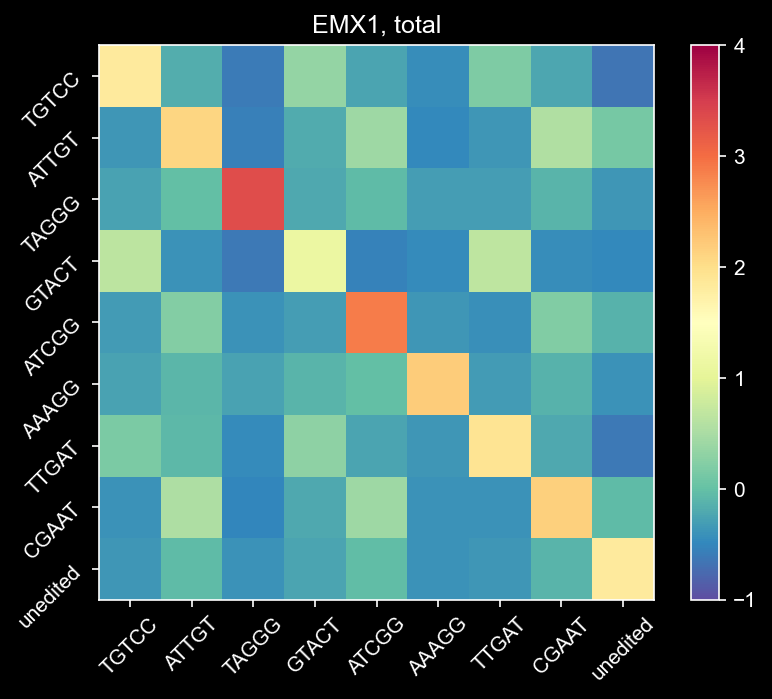

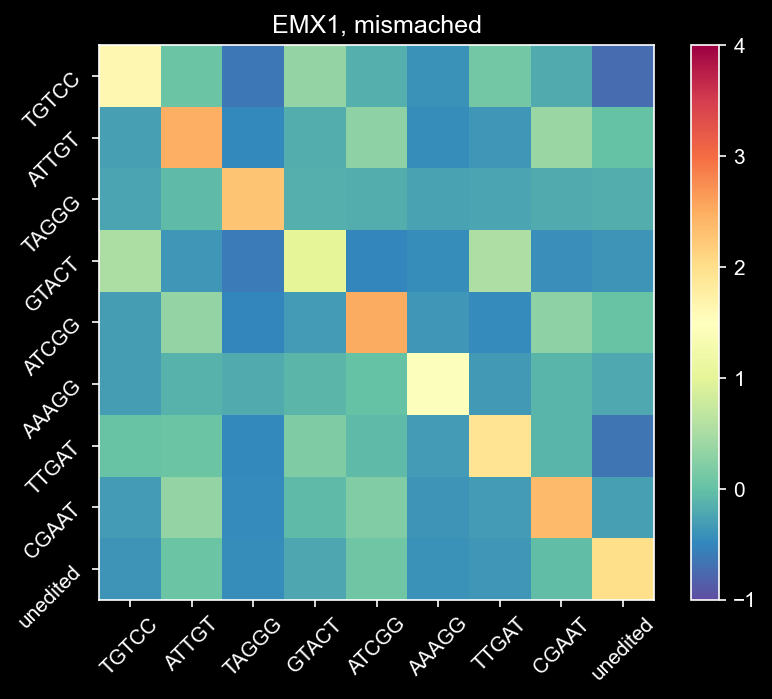

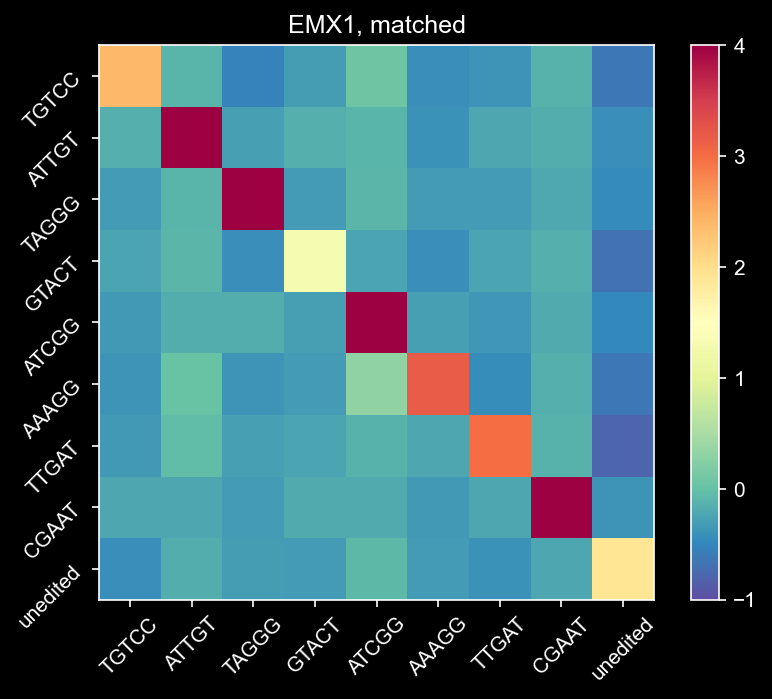

In [201]:
plt.figure(dpi=150)
plt.imshow(edit_2_zmat['EMX1'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()
plt.xticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['EMX1'],'Name'].values],
           rotation=45)
plt.yticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['EMX1'],'Name'].values],
           rotation=45)
plt.title('EMX1, total')
plt.show()

plt.figure(dpi=150)
plt.imshow(mismatched_edit_2_zmat['EMX1'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()
plt.xticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['EMX1'],'Name'].values],
           rotation=45)
plt.yticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['EMX1'],'Name'].values],
           rotation=45)
plt.title('EMX1, mismached')
plt.show()

plt.figure(dpi=150)
plt.imshow(matched_edit_2_zmat['EMX1'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()
plt.xticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['EMX1'],'Name'].values],
           rotation=45)
plt.yticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['EMX1'],'Name'].values],
           rotation=45)
plt.title('EMX1, matched')
plt.show()

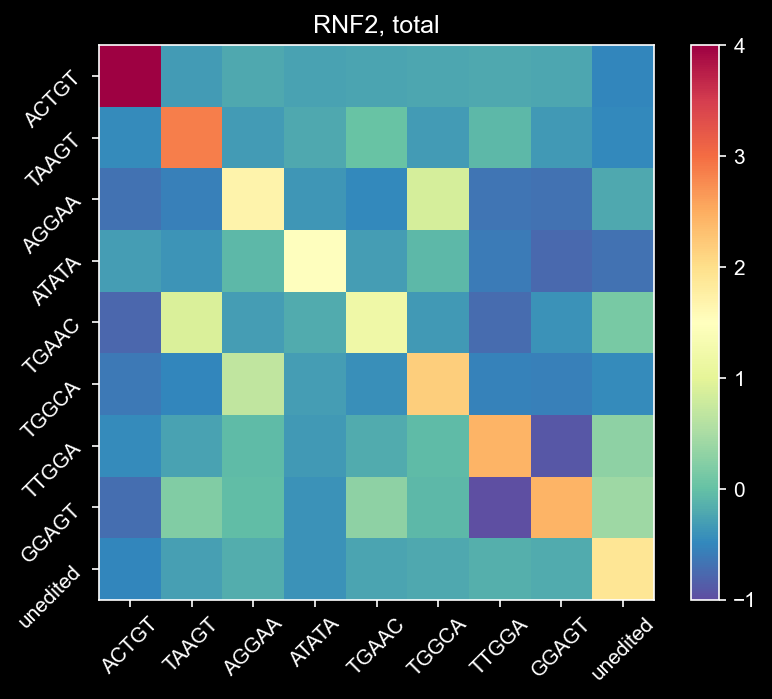

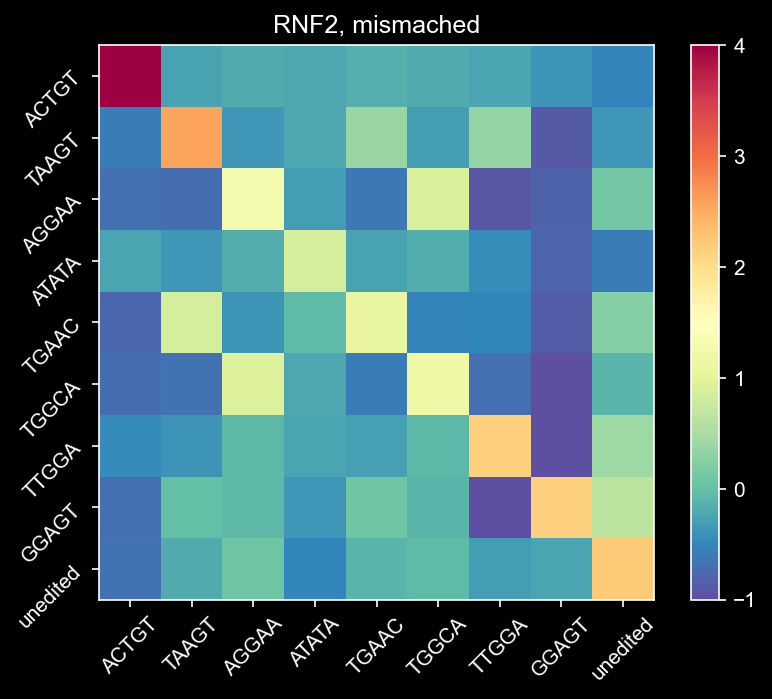

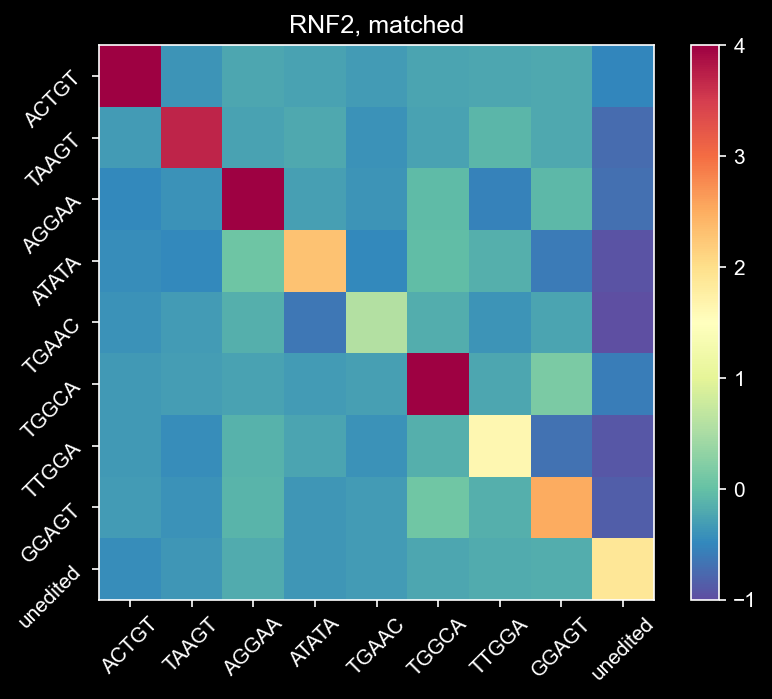

In [202]:
plt.figure(dpi=150)
plt.imshow(edit_2_zmat['RNF2'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()
plt.xticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['RNF2'],'Name'].values],
           rotation=45)
plt.yticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['RNF2'],'Name'].values],
           rotation=45)
plt.title('RNF2, total')
plt.show()

plt.figure(dpi=150)
plt.imshow(mismatched_edit_2_zmat['RNF2'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()
plt.xticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['RNF2'],'Name'].values],
           rotation=45)
plt.yticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['RNF2'],'Name'].values],
           rotation=45)
plt.title('RNF2, mismached')
plt.show()

plt.figure(dpi=150)
plt.imshow(matched_edit_2_zmat['RNF2'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()
plt.xticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['RNF2'],'Name'].values],
           rotation=45)
plt.yticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['RNF2'],'Name'].values],
           rotation=45)
plt.title('RNF2, matched')
plt.show()

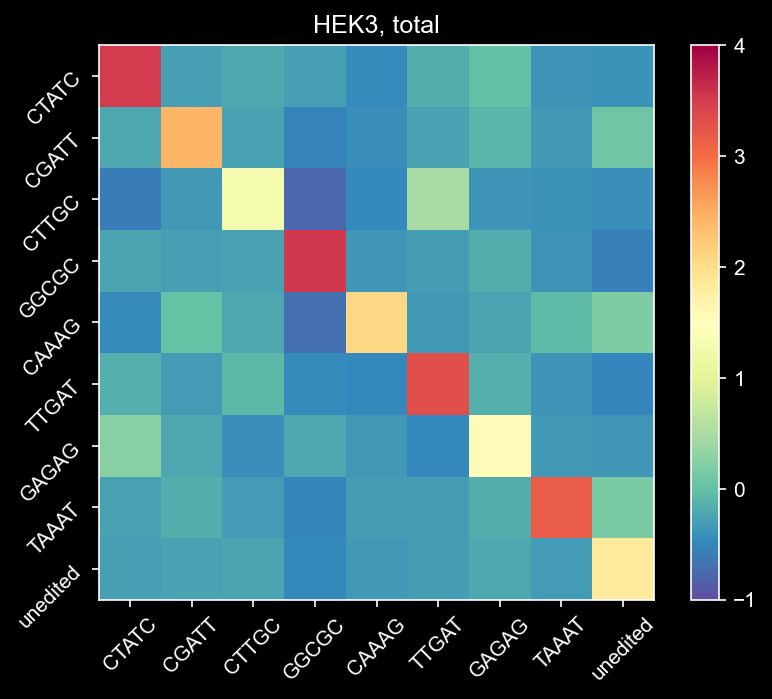

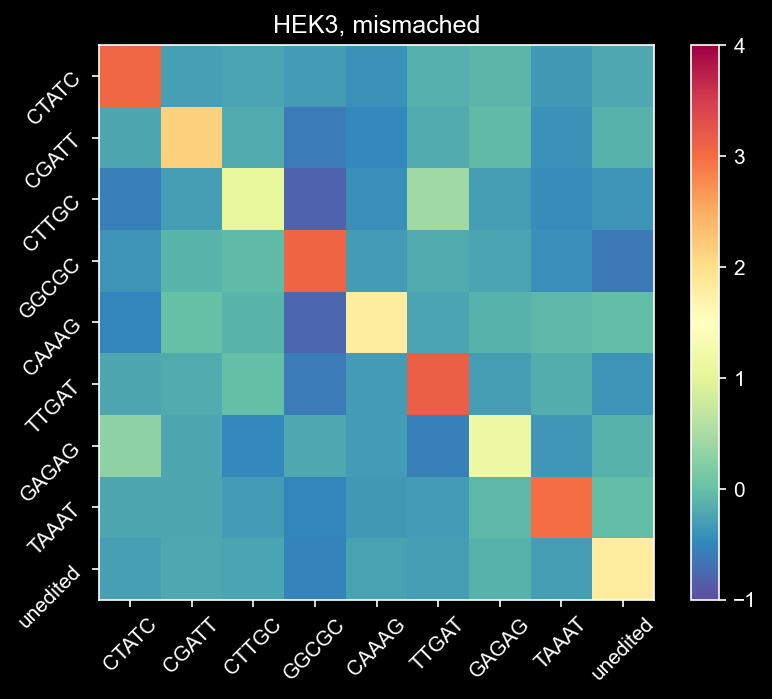

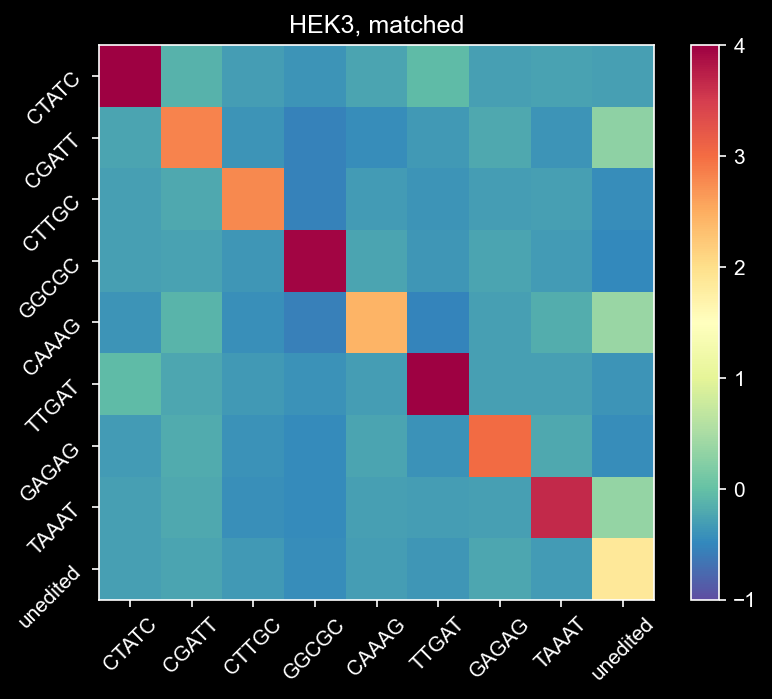

In [203]:
plt.figure(dpi=150)
plt.imshow(edit_2_zmat['HEK3'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()
plt.xticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['HEK3'],'Name'].values],
           rotation=45)
plt.yticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['HEK3'],'Name'].values],
           rotation=45)
plt.title('HEK3, total')
plt.show()

plt.figure(dpi=150)
plt.imshow(mismatched_edit_2_zmat['HEK3'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()
plt.xticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['HEK3'],'Name'].values],
           rotation=45)
plt.yticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['HEK3'],'Name'].values],
           rotation=45)
plt.title('HEK3, mismached')
plt.show()

plt.figure(dpi=150)
plt.imshow(matched_edit_2_zmat['HEK3'], vmax=4, vmin=-1, cmap='Spectral_r')
plt.colorbar()
plt.xticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['HEK3'],'Name'].values],
           rotation=45)
plt.yticks(np.arange(9), [_n.split('_')[-1] for _n in preEdit_probebook.loc[site_2_indices['HEK3'],'Name'].values],
           rotation=45)
plt.title('HEK3, matched')
plt.show()

17

In [139]:
plt.style.use('dark_background')

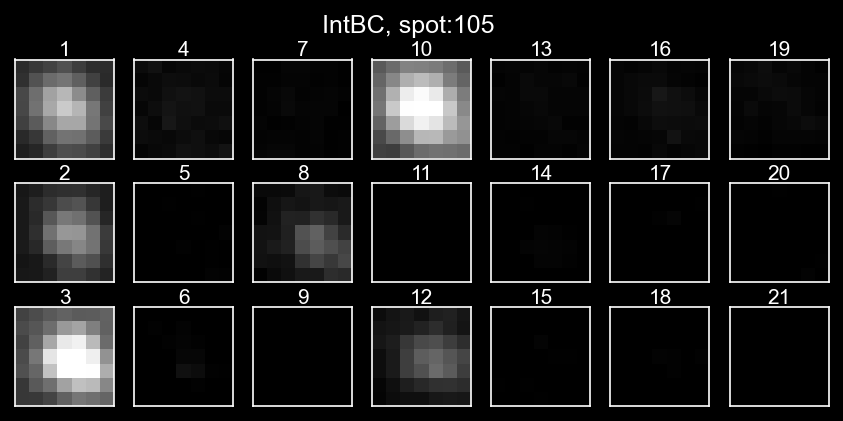

In [140]:
_sid = 105
normalized_intbc_ims = (optimize_obj.ims[_sid] - optimize_obj.backgrounds[:,np.newaxis,np.newaxis,np.newaxis]) / optimize_obj.scale_factors[:,np.newaxis,np.newaxis,np.newaxis]        
intbc_ids = np.arange(1,22)
optimize_obj.barcode_ids[_sid]


# site 1 image
fig, axes = plt.subplots(3,int(len(normalized_intbc_ims)/3), sharex=True, sharey=True, 
                         figsize=(len(normalized_intbc_ims)/3,3), dpi=150)
plt.subplots_adjust(wspace=0.2, hspace=0.25)
for _iax, ax in enumerate(np.ravel(axes.transpose())):
    ax.imshow(normalized_intbc_ims[_iax].max(0), 
              vmin=0, 
              vmax=scoreatpercentile(normalized_intbc_ims, 99.9), cmap='Greys_r')
    #ax.set_axis_off()
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False) 
    if _iax < len(normalized_intbc_ims):
        ax.set_title(f"{intbc_ids[_iax]}", fontsize=10, pad=1)
    else:
        pass
        #ax.set_title("unedited", fontsize=10)

fig.suptitle(f'IntBC, spot:{_sid}', fontsize=12)
fig.savefig(os.path.join(figure_folder,
                         f"temp_IntBC_decode_{_sid}.png"),
            transparent=True,
           )
plt.show()

In [129]:
figure_folder


'/lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907/Analysis/saved_figures_20231018'

In [145]:
axes

array([[<Axes: title={'center': '25'}>, <Axes: title={'center': '28'}>,
        <Axes: title={'center': '31'}>, <Axes: title={'center': '34'}>,
        <Axes: title={'center': '37'}>, <Axes: title={'center': '40'}>,
        <Axes: title={'center': '43'}>, <Axes: title={'center': '46'}>,
        <Axes: title={'center': '49'}>],
       [<Axes: title={'center': '26'}>, <Axes: title={'center': '29'}>,
        <Axes: title={'center': '32'}>, <Axes: title={'center': '35'}>,
        <Axes: title={'center': '38'}>, <Axes: title={'center': '41'}>,
        <Axes: title={'center': '44'}>, <Axes: title={'center': '47'}>,
        <Axes: title={'center': '50'}>],
       [<Axes: title={'center': '27'}>, <Axes: title={'center': '30'}>,
        <Axes: title={'center': '33'}>, <Axes: title={'center': '36'}>,
        <Axes: title={'center': '39'}>, <Axes: title={'center': '42'}>,
        <Axes: title={'center': '45'}>, <Axes: title={'center': '48'}>,
        <Axes: title={'center': '51'}>]], dtype=object

In [166]:
_sid = 100

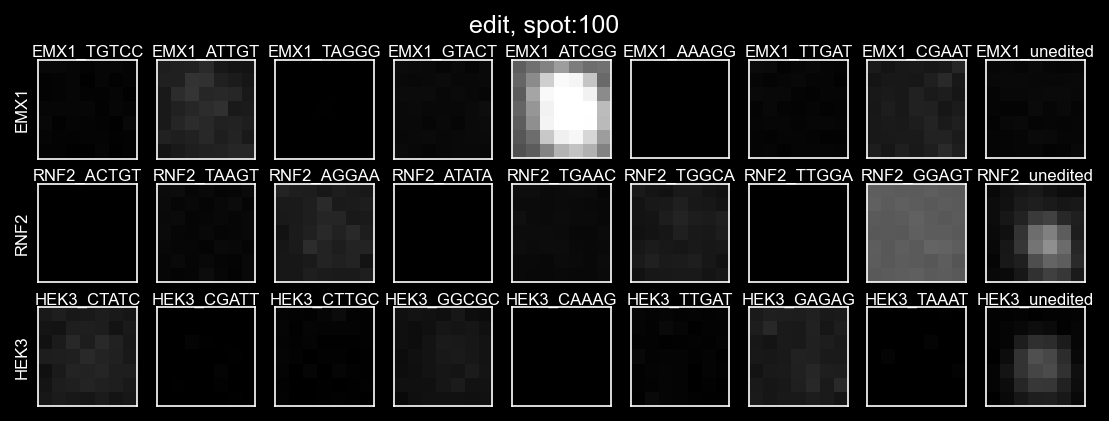

In [167]:
normalized_edit_ims = (edit_obj.ims[_sid] - edit_obj.backgrounds[:,np.newaxis,np.newaxis,np.newaxis]) \
    / edit_obj.scale_factors[:,np.newaxis,np.newaxis,np.newaxis]        
edit_ids = np.arange(25,52)
optimize_obj.barcode_ids[_sid]


# site 1 image
fig, axes = plt.subplots(3,int(len(normalized_edit_ims)/3), sharex=True, sharey=True, 
                         figsize=(len(normalized_edit_ims)/3,3), dpi=150)
plt.subplots_adjust(wspace=0.2, hspace=0.25)

for _site, _row_axes in zip(site_2_indices, axes):
    for _iax, _ax in enumerate(_row_axes):
        _idx = site_2_indices[_site][_iax]
        _ax.imshow(normalized_edit_ims[_idx].max(0), 
                   vmin=0, 
                   vmax=scoreatpercentile(normalized_edit_ims, 99.9), cmap='Greys_r')
        _ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        # probename
        _probe_name = preEdit_probebook.loc[_idx, 'Name']
        _ax.set_title(f"{_probe_name.split('_')[1]}_{_probe_name.split('_')[-1]}", fontsize=8, pad=1)
        if _iax == 0:
            _ax.set_ylabel(f"{_site}", fontsize=8)

fig.suptitle(f'edit, spot:{_sid}', fontsize=12)
fig.savefig(os.path.join(figure_folder,
                         f"temp_edit_decode_{_sid}.png"),
            transparent=True,
           )
plt.show()

In [204]:
rep1_counts = counts
rep2_counts = [382, 2796, 1100]


In [205]:
rep1_percentage = rep1_counts / np.sum(rep1_counts)
rep2_percentage = rep2_counts / np.sum(rep2_counts)

([<matplotlib.axis.XTick at 0x7f2204563160>,
 [Text(1, 0, 'rep1'), Text(2, 0, 'rep2')])

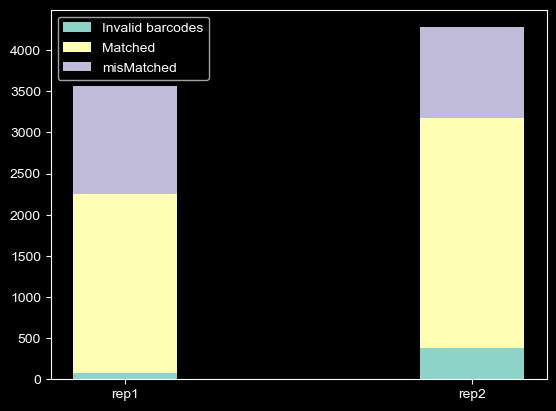

In [206]:
plt.figure()
plt.bar([1,2], [rep1_counts[0], rep2_counts[0]], 
        width=0.3, label='Invalid barcodes')
plt.bar([1,2], [rep1_counts[1], rep2_counts[1]], 
        bottom=[rep1_counts[0], rep2_counts[0]], 
        width=0.3, label='Matched')
plt.bar([1,2], [rep1_counts[2], rep2_counts[2]], 
        bottom=[rep1_counts[0]+rep1_counts[1], rep2_counts[0]+rep2_counts[1]], 
        width=0.3, label='misMatched')
plt.legend()
plt.xticks([1,2],['rep1', 'rep2'])
#plt.xticks()

([<matplotlib.axis.YTick at 0x7f220406eaa0>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9'),
  Text(0, 1.0, '1.0')])

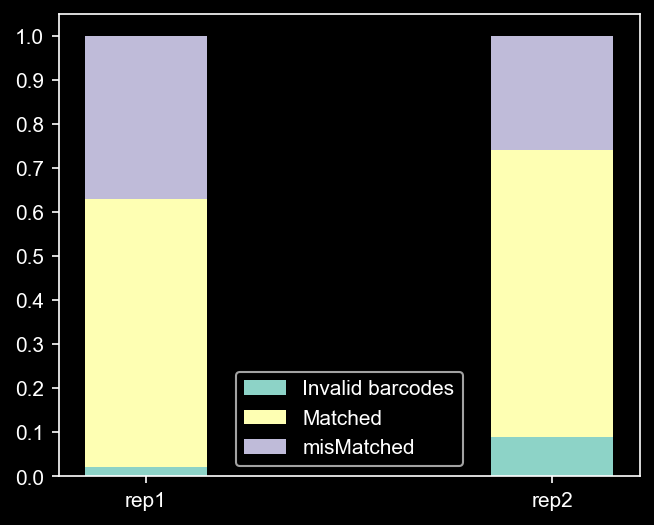

In [211]:
plt.figure(figsize=(5,4), dpi=150)
plt.bar([1,2], [rep1_percentage[0], rep2_percentage[0]], 
        width=0.3, label='Invalid barcodes')
plt.bar([1,2], [rep1_percentage[1], rep2_percentage[1]], 
        bottom=[rep1_percentage[0], rep2_percentage[0]], 
        width=0.3, label='Matched')
plt.bar([1,2], [rep1_percentage[2], rep2_percentage[2]], 
        bottom=[rep1_percentage[0]+rep1_percentage[1], rep2_percentage[0]+rep2_percentage[1]], 
        width=0.3, label='misMatched')
plt.legend()
plt.xticks([1,2],['rep1', 'rep2'])
plt.yticks(np.arange(0,1.1,0.1))
#plt.xticks()

array([-0.58260378,  3.38908226, -0.59307001, -0.55130411, -0.04773193,
       -0.59584931, -0.56462951,  0.07402345, -0.52331638, -0.39880196,
       -0.08540607, -0.52253452, -0.33420027, -0.00597135, -0.53619148,
       -0.68122216,  0.33981964, -0.52361041, -0.58285484, -0.08842028,
       -0.47014768, -0.70987162, -0.29221421, -0.63463819,  2.13645077,
        1.60221259,  1.78300133])

In [276]:
optimize_obj.barcode_ids[0]

101

In [240]:
def _decode_foci(
    self, 
    image_series=None, 
    codebook:pd.DataFrame=None,
    scale_factors:np.ndarray=None,
    backgrounds:np.ndarray=None,
    distance_threshold:int=1.44,
    magnitute_threshold:int=1,
    lowpass_threshold:int=1,        
    ) -> int:
    """
    Assign barcodes to each foci
    Each image_series has been preprocessed and aligned, 
    then according to the scaling factor and background, 
    this focus is normalized into a vector and assigned to specific barcode based on Euclidean distance
    to one of the existing barcode
    """
    # Inputs
    if image_series is None:
        # num_foci x num_bits x dx x dy x dz
        image_series = self.ims
    if scale_factors is None:
        scale_factors = self.scale_factors
    if backgrounds is None:
        backgrounds = self.backgrounds
    if codebook is None:
        codebook = self.codebook
    _codebook_mat = codebook.iloc[:,1:].values # get codebook mat
    # init assigned_infos:
    self.barcode_ids, self.barcode_dists, self.barcode_mags = [], [], []
    # normalize images
    for _i, _images in enumerate(image_series):
        #_signal_series = scoreatpercentile(_images.reshape((_images.shape[0],-1)), 95, axis=1)
        _signal_series = _images 
        _normalized_series = (_signal_series - backgrounds[:,np.newaxis,np.newaxis,np.newaxis]) / scale_factors[:,np.newaxis,np.newaxis,np.newaxis]        
        # refit, anything not fully normalized forced to be 1 at max
        #_normalized_barcode = np.array([min(scoreatpercentile(_n,99.9),1) for _n in _normalized_series])
        _normalized_barcode = np.array([min(np.max(_n),1) for _n in _normalized_series])
        # calculate Euclidian distance to existing barcodes 
        _barcode_dists = np.linalg.norm(_codebook_mat - _normalized_barcode, axis=1) 
        # check if this could be assigned:
        if np.min(_barcode_dists) < distance_threshold:
            _assigned_barcode_id = np.argmin(_barcode_dists)
            _assigned_dist = np.min(_barcode_dists)
            #print(np.sort(_barcode_dists)[:2])
            # calculate magnitute:
            _assigned_mag = np.linalg.norm(_normalized_barcode[_codebook_mat[_assigned_barcode_id]])
            #print(_assigned_barcode_id, _assigned_dist, _assigned_mag)
        else:
            print(np.sort(_barcode_dists)[:2])
            _assigned_barcode_id = -1
            _assigned_dist = np.inf
            _assigned_mag = np.inf
        #break
        #self.barcode_ids.append(_assigned_barcode_id)
        #self.barcode_dists.append(_assigned_dist)
        #self.barcode_mags.append(_assigned_mag)

    return barcode_ids, barcode_dists, barcode_mags

<IPython.core.display.Javascript object>


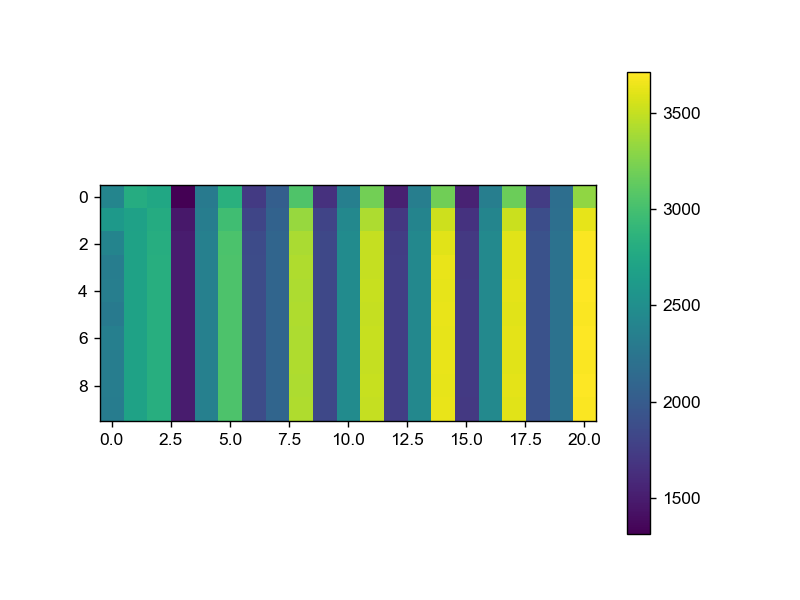

In [225]:
plt.figure()
plt.imshow(np.array(optimize_obj.prev_backgrounds))
plt.colorbar()

<IPython.core.display.Javascript object>


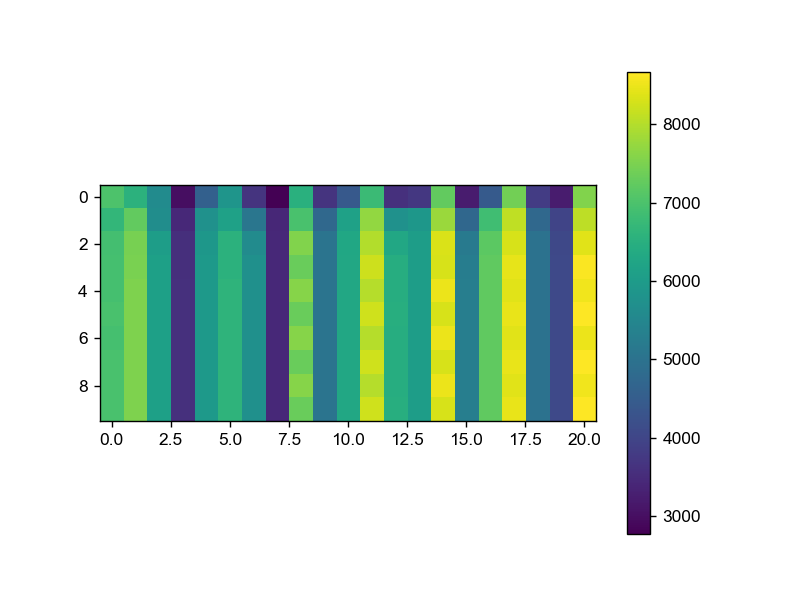

In [226]:
plt.figure()
plt.imshow(np.array(optimize_obj.prev_scale_factors))
plt.colorbar()

<IPython.core.display.Javascript object>


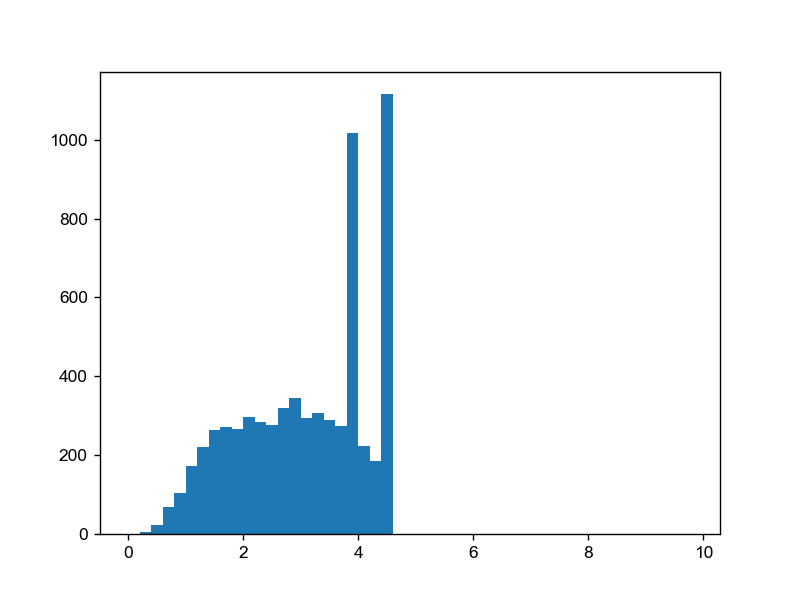

In [124]:
plt.figure()
plt.hist(np.array(optimize_obj.barcode_mags),bins=np.arange(0,10,0.2))
plt.show()

<IPython.core.display.Javascript object>


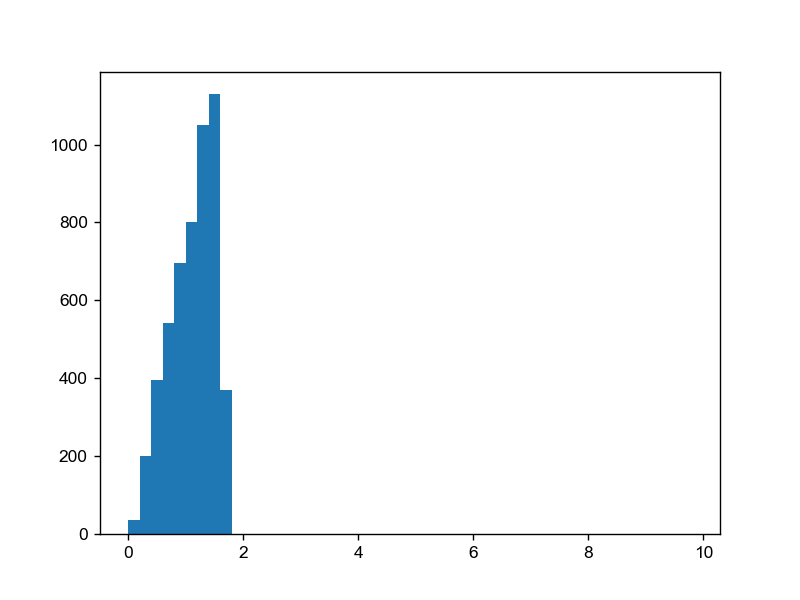

In [227]:
plt.figure()
plt.hist(np.array(optimize_obj.barcode_dists),bins=np.arange(0,10,0.2))
plt.show()

In [62]:
# dist allowing linear regression
from sklearn.linear_model import LinearRegression
_background_mag = 1
_signal_mag = 1


In [85]:
_image_series = np.max(optimize_obj.ims[0], axis=(1,2,3))
coefs, intercepts, scores = [], [], []
for _ibc, _barcode in enumerate(codebook_mat):
    # normalize:
    backgrounds = optimize_obj.backgrounds
    scale_factors = optimize_obj.scale_factors
    # define XY
    X, y = np.transpose([backgrounds*_barcode, scale_factors*_barcode]), _image_series * _barcode
    model = LinearRegression(positive=True, fit_intercept=True)
    model.fit(X, y)
    coefs.append(model.coef_)
    intercepts.append(model.intercept_)
    scores.append(model.score(X, y))

<IPython.core.display.Javascript object>


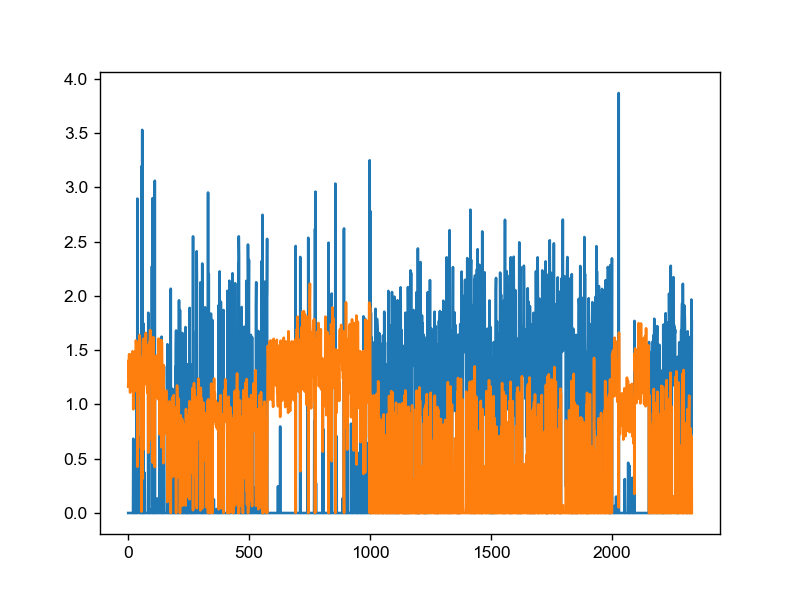

In [91]:
plt.figure()
plt.plot(np.array(coefs))

<IPython.core.display.Javascript object>


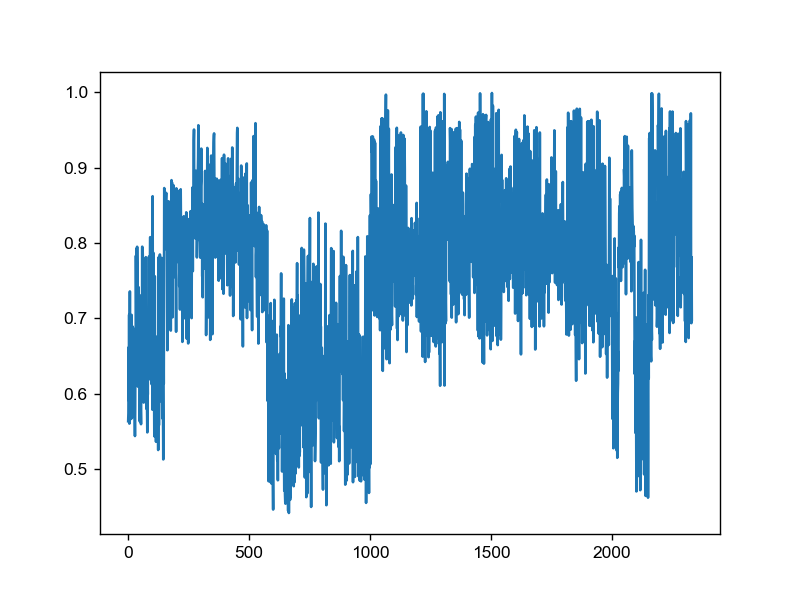

In [88]:

plt.figure()
plt.plot(scores)

0.16962473870632444

(array([0.2885317 , 0.88399317]), -67.12336972597586)

In [69]:
_image_series

array([ 7967, 18425,  2789,  1636,  4122,  7679,  1783,  3430,  3445,
        1789,  3602,  3593,  1737,  3765, 10893,  1750,  5141,  3726,
        6885,  7814,  3544], dtype=uint16)

In [37]:
np.max(normed_series, axis=(1,2,3))

array([0.79118065, 2.37863339, 0.00782779, 0.107     , 0.39733217,
       0.82789267, 0.01586867, 0.50361011, 0.05994467, 0.03666211,
       0.28509866, 0.05705043, 0.05905292, 0.38430529, 1.06033058,
       0.06348715, 0.63169743, 0.07422875, 1.34590207, 1.74326417,
       0.03031105])

In [39]:
codebook_mat = codebook.iloc[:,1:].values

In [61]:
codebook

,Unnamed: 0,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,...,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_20
0,intbc_0,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,intbc_1,1,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,intbc_2,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,intbc_3,1,1,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,intbc_4,1,1,1,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,blank_325,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,1,0,0,1
2326,blank_326,0,0,0,0,0,0,0,0,1,...,0,1,1,1,1,0,0,0,0,1
2327,blank_327,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,1,1,1
2328,blank_328,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,0,0


In [49]:
np.min(barcode_dists), np.argmin(barcode_dists)

(1.0708112559355, 101)

In [51]:
np.argsort(barcode_dists)[:10]

array([101, 786, 934, 815,  91, 148, 999,  73, 526,  96])

In [50]:
np.sort(barcode_dists)[:10]

array([1.07081126, 1.71088091, 1.80490272, 1.8219506 , 1.83597547,
       1.84134997, 1.86793964, 1.93316907, 1.93989598, 1.93993622])

<IPython.core.display.Javascript object>


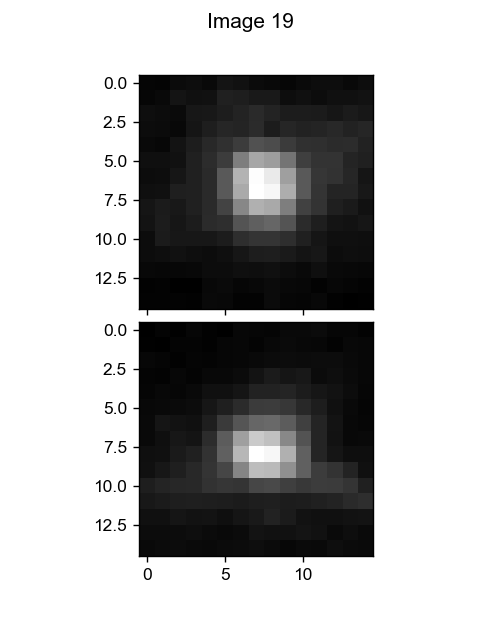

In [82]:
%matplotlib notebook
interactive.imshow_mark_3d(normed_series)

In [21]:
norm[:,7,7,7], norm[:,8,8,8]

NameError: name 'norm' is not defined

In [22]:
np.sort(np.max(dists, axis=(1,2,3)))[:5], np.argsort(np.max(dists, axis=(1,2,3)))[:5]#, np.min(np.max(dists, axis=(1,2,3)))

NameError: name 'dists' is not defined

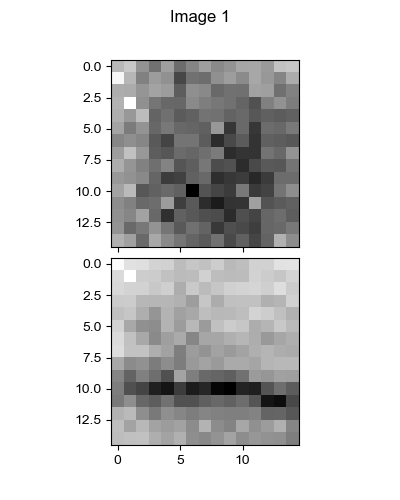

In [233]:
interactive.imshow_mark_3d(dists[np.array([101,815,999])])

array([[1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

In [35]:
cumHist = np.cumsum(all_intbc_ims, axis=1)

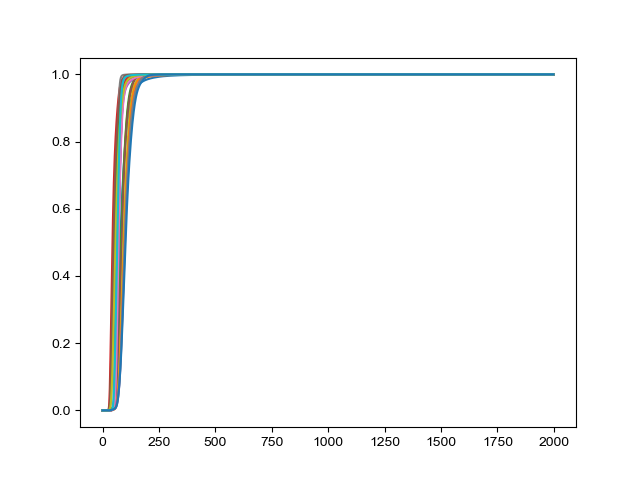

In [98]:
plt.figure()
plt.plot(np.array(all_cumHist).transpose(),)
plt.show()

0 4604.0 2345.0
1 4178.0 2605.0
2 4015.0 2435.0
3 2442.0 1235.0
4 3261.0 2205.0
5 4113.0 2625.0
6 2802.0 1585.0
7 2442.0 1995.0
8 4441.0 2875.0
9 2835.0 1635.0
10 3130.0 2255.0
11 4539.0 2925.0
12 2900.0 1425.0
13 3064.0 2205.0
14 4867.0 3035.0
15 2606.0 1355.0
16 3228.0 2255.0
17 4801.0 3015.0
18 3064.0 1705.0
19 2802.0 2025.0
20 5063.0 3085.0


In [ ]:
len(all_intbc_ims)

1708

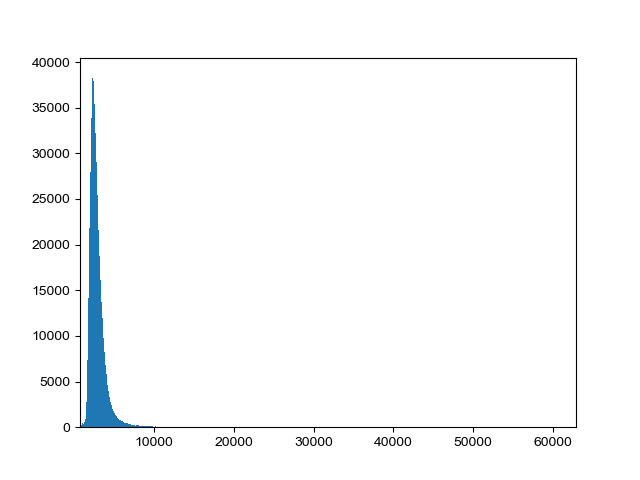

2345.0

In [ ]:
find_image_background(np.array(all_intbc_ims)[:,0], make_plot=True)

In [ ]:
np.iinfo(data_type).max

65535

In [ ]:
pixelHist

(array([5693805,   61808,    6514,    1545,     533,     193,      58,
             29,      10,       5]),
 array([  694. ,  6914.1, 13134.2, 19354.3, 25574.4, 31794.5, 38014.6,
        44234.7, 50454.8, 56674.9, 62895. ]))

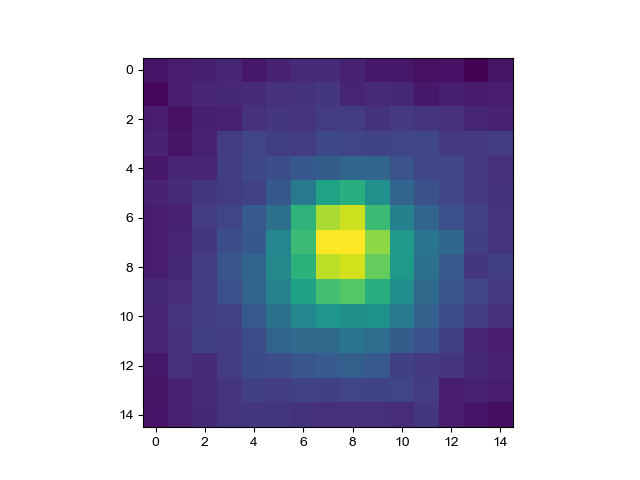

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cumHist[0][0].mean(0))
plt.show()

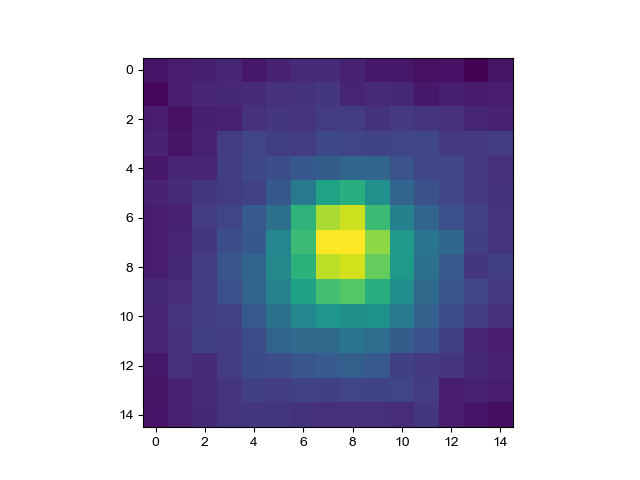

In [ ]:
plt.figure()
plt.imshow(all_intbc_ims[0][0].mean(0))
plt.show()

In [214]:
# save this object:
intbc_save_filename = os.path.join(save_folder, 'intbc_decoder.pkl')
print(intbc_save_filename)
with open(intbc_save_filename, 'wb') as _f:
    pickle.dump(optimize_obj, _f)

/lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907/Analysis/intbc_decoder.pkl


In [215]:
# save this object:
edit_save_filename = os.path.join(save_folder, 'edit_decoder.pkl')
print(edit_save_filename)
with open(edit_save_filename, 'wb') as _f:
    pickle.dump(edit_obj, _f)

/lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907/Analysis/edit_decoder.pkl


In [216]:
# load
loaded_intbc_obj = pickle.load(open(intbc_save_filename, 'rb'))
loaded_edit_obj = pickle.load(open(edit_save_filename, 'rb'))

In [220]:
loaded_intbc_obj.ims.shape

(6895, 21, 7, 7, 7)